In [0]:
#@title Import packages
import numpy as np, pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels
import seaborn as sns
from __future__ import division

import warnings
warnings.filterwarnings("ignore")


# Data IO


In [2]:
# read data from local drive using Jupyter notebook mode
import pandas as pd
df=pd.read_csv('.../nyc_yellow_trip_201210_sample_processed.csv', index_col=None,\
              sep=',')


FileNotFoundError: ignored

# Business Questions
Before entering a new market, we estimate the market volume/demand from user segment perspectives by analyzing NYC taxi pick up and dropoff data.  <br>
Demand comes from resource scarcity and substitution effect:   

* High taxi demand but short taxi supply
* High ride cost

Assumption:


*   Distance range<br>
20-30 mins ride time, about 5 miles
*   Each user has only one ride







# Data Preprocessing Using Domain Knowledge


* Remove trip_distance<=0.15 mile

* Remove coordinate data outside NYC




In [0]:
# remove trip_distance<=0.15
df.drop(df[df.trip_distance<=0.15].index, inplace=True)
# remove null value
df.dropna(inplace=True)
# remove out-of-range data from coordinate system 
# longtitude normal range is from [-180,180], latitude [-90,90]; remove (0,0)

df=df[((np.modf(df.pickup_longitude)[1]==-73.0)|(np.modf(df.pickup_longitude)[1]==-74.0))&\
                         (np.modf(df.pickup_latitude)[1]==40.0)]

# remove locations not in New York City : (40.705542,-74.018415), (40.851476, -73.884222)
df=df[(df.pickup_latitude >= 40.705542) & (df.pickup_latitude <= 40.851476)\
               &(df.pickup_longitude>=-74.018415) & (df.pickup_longitude <=-73.884222)]

df.index=np.arange(df.shape[0])

In [0]:
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount
0,2012-10-01 07:57:14,2012-10-01 08:07:03,1,1.70,-73.993948,40.751194,-73.972795,40.755737,CRD,2.25,11.25
1,2012-10-01 07:57:55,2012-10-01 08:01:37,3,0.40,-73.978451,40.759869,-73.987742,40.751957,CSH,0.00,5.00
2,2012-10-01 07:57:00,2012-10-01 08:06:00,1,1.19,-73.954290,40.784127,-73.966245,40.789810,CRD,1.00,9.50
3,2012-10-01 07:57:00,2012-10-01 08:18:00,1,3.22,-73.939198,40.791792,-73.972487,40.760687,CRD,1.00,17.00
4,2012-10-01 07:57:27,2012-10-01 08:02:14,1,0.80,-73.960658,40.769850,-73.968667,40.764806,CRD,1.20,7.20


# Exploratory Analysis

## Distribution

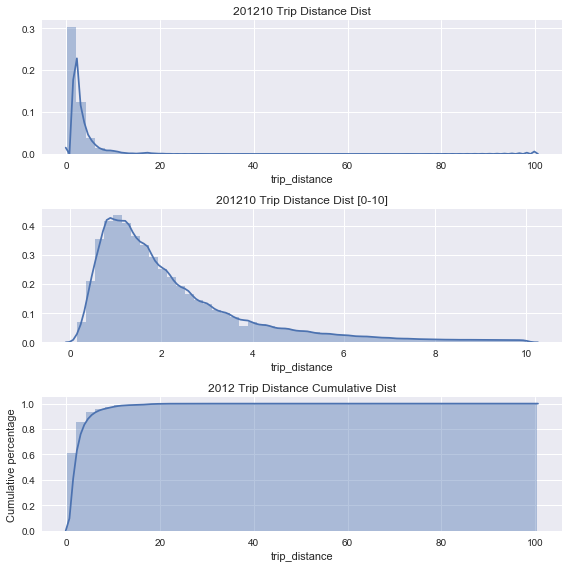

In [0]:
# Trip distance Distribution
fig=plt.figure(figsize=(8,8))
ax0=fig.add_subplot(3,1,1)
sns.distplot(df.trip_distance,ax=ax0)
ax0.set_title('201210 Trip Distance Dist')

ax1=fig.add_subplot(3,1,2)
sns.distplot(df.trip_distance[df.trip_distance<=10],ax=ax1)
ax1.set_title('201210 Trip Distance Dist [0-10]')

# cumulative distributio of trip distance
ax2=fig.add_subplot(3,1,3)
sns.distplot(df.trip_distance,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
             ax=ax2)
ax2.set_ylabel('Cumulative percentage')
ax2.set_title('2012 Trip Distance Cumulative Dist')

plt.tight_layout();

In [0]:
# Initially, was trying to find the cut-off point for 80% cumulative distribution.
# However, that's 11.34miles (45 mins bike ride), too aggressive.
trip_sort=np.sort(df['trip_distance'])
trip_cumu_sort=np.cumsum(np.sort(df['trip_distance']))/df['trip_distance'].sum()
trip_sort[np.min(np.where(trip_cumu_sort>=0.8))] # 11.34 miles to 45mins

# Let's find distance for within 20 mins bike, approximately 5 miles
# 65% of rides is within 20 mins bike distance, 1,237,439 rides in 201210
np.sum(trip_sort[np.where(trip_sort<=5)])/df['trip_distance'].sum()


0.64984711632712133

In [0]:
df_5_mi=df.loc[df['trip_distance']<=5,:]
df_5_mi.index=np.arange(df_5_mi.shape[0])

df_5_mi=df_5_mi[((np.modf(df_5_mi.pickup_longitude)[1]==-73.0)|(np.modf(df_5_mi.pickup_longitude)[1]==-74.0))&\
                         (np.modf(df_5_mi.pickup_latitude)[1]==40.0)]

# remove locations not in New York City : (40.705542,-74.018415), (40.851476, -73.884222)
df_5_mi=df_5_mi[(df_5_mi.pickup_latitude >= 40.705542) & (df_5_mi.pickup_latitude <= 40.851476)\
               &(df_5_mi.pickup_longitude>=-74.018415) & (df_5_mi.pickup_longitude <=-73.884222)]

df_5_mi.index=np.arange(df_5_mi.shape[0])

In [0]:
# Data sanity check
np.where(pd.isnull(df_5_mi.pickup_longitude))

(array([], dtype=int64),)

## Coordinate Data Visualization

In [0]:
# Google Map Visualization
# random sampled 10,000 rows from df_5_mi
np.random.seed(50)
loc_pickup_sample_index=np.random.choice(df_5_mi.shape[0],10000,replace=False)
loc_pickup_total=df_5_mi.loc[loc_pickup_sample_index]
loc_pickup_total.index=np.arange(loc_pickup_total.shape[0])
loc_pickup=loc_pickup_total[['pickup_latitude','pickup_longitude']]
loc_pickup.columns=['latitude','longitude']
loc_pickup.index=np.arange(loc_pickup.shape[0])


In [0]:
# pickup location is uniformly distributed
import gmaps
import gmaps.datasets
gmaps.configure(api_key='')
new_york_coordinates = (40.75, -74.00)
fig=gmaps.figure(center=new_york_coordinates, zoom_level=12)
fig.add_layer(gmaps.heatmap_layer(loc_pickup))
fig

Figure(layout=FigureLayout(height='420px'))

## Seasonality Check

In [0]:
loc_pickup_total['dropoff_datetime']= pd.to_datetime(loc_pickup_total['dropoff_datetime'])
loc_pickup_total['pickup_datetime']= pd.to_datetime(loc_pickup_total['pickup_datetime'])

loc_pickup_total['p_weekday'] = loc_pickup_total.pickup_datetime.dt.weekday_name

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

loc_pickup_total['p_weekday'] = pd.Categorical(loc_pickup_total['p_weekday'], categories=day_order, ordered=True)
loc_pickup_total['p_month'] = loc_pickup_total.pickup_datetime.dt.month
loc_pickup_total['p_day'] = loc_pickup_total.pickup_datetime.dt.day
loc_pickup_total['p_hour'] = loc_pickup_total.pickup_datetime.dt.hour
loc_pickup_total['p_minute'] = loc_pickup_total.pickup_datetime.dt.minute

In [0]:
loc_pickup_total_weekly=loc_pickup_total.groupby(['p_weekday','p_hour'],as_index=False).agg({'pickup_datetime':'count'}).rename(columns={'pickup_datetime':'ride_count'})
loc_pickup_total_weekly=loc_pickup_total_weekly.sort_index()
loc_pickup_total_weekly.head()

,p_weekday,p_hour,ride_count
0,Monday,0,24
1,Monday,1,15
2,Monday,2,14
3,Monday,3,6
4,Monday,4,4


In [0]:
# Define color template
tableau_color_blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

for i in range(len(tableau_color_blind)):  
    r, g, b = tableau_color_blind[i]  
    tableau_color_blind[i] = (r / 255., g / 255., b / 255.)
    
current_palette = sns.color_palette(tableau_color_blind)


Text(0.5,0,'Hour')

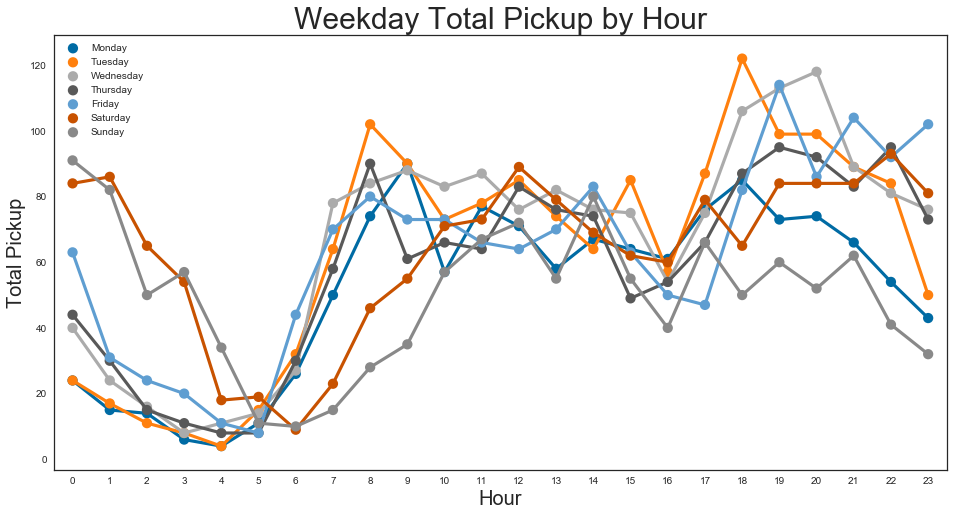

In [0]:
## create figure
sns.set_style("white")
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

current_palette = sns.color_palette(tableau_color_blind)

## plot data
# sns.pointplot(ax=ax, x='p_weekday',y='ride_count', hue='p_weekday',,linestyles=["-"],
#               palette = current_palette, data = loc_pickup_total_weekly)
sns.pointplot(ax=ax, x='p_hour',y='ride_count',hue='p_weekday',  
         data=loc_pickup_total_weekly, palette = current_palette)

plt.legend(loc='upper left')

## format plot labels
ax.set_title('Weekday Total Pickup by Hour', fontsize=30)
ax.set_ylabel('Total Pickup', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

Weekend: More rides in the mid-night and noon.
Weekday: bimodal distribution due to morning and evening commute

# Market Volume Analysis

# Ride Clustering
find popular pick up locations that have X minimum pickups with Y maximum distance kilo-meters from each other.
Popular clustering algorithms: kmeans family, DBSCAN.
Kmeans is likely the most common clustering algorithm but not good for spatial data. It's not easy to know ahead the number of K. DBSCAN seems to correspond more to human intuitions of clustering: minimum number of points in a cluster, maximum distance from each other. 



In [0]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [0]:
# DBSCAN clustering, return cluster centroid and number of points
# for DBSCAN, points can't be clustered will be categorized as 0_cluster
def dbscan_clustering(max_distance,min_sample,ride_data):
    ## Data extraction
    coords=ride_data.as_matrix(columns=['latitude', 'longitude'])
    ## model parameters
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    cluster_labels = db.labels_   
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in np.unique(cluster_labels)]) # cluster_labels == n will return index
    
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for centroids and its clusters
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):
        ## filter empty clusters
        if clusters[ii].any():
            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    cluster_spots = [lat,lon,num_members]
    cluster_spots = np.transpose(np.array(cluster_spots))
    return (cluster_spots, clusters, cluster_labels)
    

In [0]:
max_distance = 0.1 # in kilometers
min_pickups = 15

# the first cluster is noise cluster, need to be removed
hot_spots,dbscan_clusters, cluster_labels= dbscan_clustering(max_distance ,min_pickups, loc_pickup)
# (0.02 + 10): 13, (0.1+50):6, () 

Number of clusters: 65


In [0]:
# heatmap+ markplace
hot_spots_df=pd.DataFrame(data=hot_spots[1:],index=np.arange(hot_spots.shape[0]-1),
                         columns=['latitude','longitude','spots'])
dbscan_clusters_noise_free =  dbscan_clusters[1:] 
index_clean_pickup=loc_pickup.index[-np.where(cluster_labels==-1)[0]]

loc_pickup_noise_free=loc_pickup.iloc[index_clean_pickup]

new_york_coordinates = (40.75, -74.00)
fig=gmaps.figure(center=new_york_coordinates, zoom_level=12)

## Add heatmap layer
rawdata_heatmap=gmaps.heatmap_layer(loc_pickup_noise_free)
fig.add_layer(rawdata_heatmap)

## Add symbol layer
symbol_layer = gmaps.symbol_layer(hot_spots_df[['latitude','longitude']], 
                                     fill_color='rgba(100, 100, 246, 1)',
                                     stroke_color='rgba(100, 100, 246, 1)', scale=3)
fig.add_layer(symbol_layer)

## Add marks layer
info_box_template = """
<dl>
<dt>Pick_ups</dt><dd>{Pick_ups}</dd>
</dl>
"""
dt_labels=[{'Pick_ups':spot} for spot in hot_spots_df['spots']]
pickup_num = [info_box_template.format(**spot) for spot in dt_labels]

cluster_marks=gmaps.marker_layer(hot_spots_df[['latitude','longitude']],info_box_content=pickup_num)
fig.add_layer(cluster_marks)

fig


Figure(layout=FigureLayout(height='420px'))

In [0]:
hot_spots
# 2549 points are categorized in cluster_0, accounting for less than 50% of the entire sample

array([[   40.75790209,   -73.97583729,  2549.        ],
       [   40.72521318,   -73.99456292,   179.        ],
       [   40.73941161,   -73.98301347,    59.        ],
       [   40.75724503,   -73.97866925,  4054.        ],
       [   40.76780531,   -73.95560874,   145.        ],
       [   40.7419855 ,   -73.97488378,    18.        ],
       [   40.72169965,   -73.99749892,    37.        ],
       [   40.72219458,   -73.98769436,   132.        ],
       [   40.74320141,   -73.97713265,    63.        ],
       [   40.73771561,   -73.99648381,   342.        ],
       [   40.74982975,   -73.99178995,   439.        ],
       [   40.74429844,   -73.99560033,    18.        ],
       [   40.72701857,   -73.99986667,    21.        ],
       [   40.76867212,   -73.96559909,    33.        ],
       [   40.74073539,   -74.00572831,   127.        ],
       [   40.75837279,   -73.99285482,    80.        ],
       [   40.7835981 ,   -73.95483524,    21.        ],
       [   40.73216316,   -73.9

## Demand from delta(Pickup -  Dropoff). 
假设dropoff来自pickup的sample. 或者在原来的数据集里面再sample一组dropoff的数据。这里简单起见，我们用前者。

In [0]:
# return min, max positions of a cluster
def func_min_max_pos(dbscan_clusters):
    df_clusters_min_max=pd.DataFrame(columns=['id','pickup','pickup_min_lat','pickup_min_long','pickup_max_lat',
                                             'pickup_max_long','dropoff'])
    for i in (np.arange(len(dbscan_clusters))+1): # remove the cluster_0
        min_lat=np.min(dbscan_clusters[i][:,0])
        max_lat=np.max(dbscan_clusters[i][:,0])
        min_long=np.min(dbscan_clusters[i][:,1])
        max_long=np.max(dbscan_clusters[i][:,1])
        df_clusters_min_max.loc[len(df_clusters_min_max)]=[int(i),len(dbscan_clusters[i]),
                                                          min_lat,min_long,max_lat,max_long,0] 
    return(df_clusters_min_max)
    
# can we use the original pickup random index for dropoff?
  
locations_dropoff=loc_pickup_total.loc[index_clean_pickup,['dropoff_latitude','dropoff_longitude']]
locations_dropoff.columns=['latitude','longitude']
locations_dropoff.index=np.arange(locations_dropoff.shape[0])
locations_dropoff['dedup_flag']=1 # will be used to dedup 

df_min_max_pos=func_min_max_pos(dbscan_clusters_noise_free)

# calculate the dropoff points in each cluster range and dedup
for i in np.arange(locations_dropoff.shape[0]):
    if locations_dropoff.loc[i,'dedup_flag']==1:
        for j in np.arange(df_min_max_pos.shape[0]):
            if (locations_dropoff.loc[i,'latitude']>=df_min_max_pos.loc[j,'pickup_min_lat'])\
            & (locations_dropoff.loc[i,'latitude']<=df_min_max_pos.loc[j,'pickup_max_lat'])\
            & (locations_dropoff.loc[i,'longitude']>=df_min_max_pos.loc[j,'pickup_min_long'])\
            & (locations_dropoff.loc[i,'longitude']<=df_min_max_pos.loc[j,'pickup_max_long']):
                df_min_max_pos.loc[j,'dropoff']+=1
                locations_dropoff.loc[i,'dedup_flag']=0
                break



In [0]:
df_min_max_pos.head()

,id,pickup,pickup_min_lat,pickup_min_long,pickup_max_lat,pickup_max_long,dropoff
0,1.0,179.0,40.723253,-74.000157,40.728285,-73.990119,40.0
1,2.0,59.0,40.737240,-73.984925,40.741471,-73.981253,10.0
2,3.0,4054.0,40.728407,-73.994945,40.785065,-73.955125,1481.0
3,4.0,145.0,40.765107,-73.959271,40.771204,-73.952337,13.0
4,5.0,18.0,40.741406,-73.975907,40.742957,-73.974232,0.0


In [0]:
# the gap between pickup and dropp: df_min_max_pos
np.sum(df_min_max_pos['pickup'] - df_min_max_pos['dropoff'])

5561.0

## Demand from trip time vs distance
交通繁忙的时候，需求也可以从替代效应来. <br>
Metric =  average minutes per mile.<br>
Benchmark: bike: 5 mins/mile, walk: 20 mins/mile


count    10000.000000
mean         5.752400
std          4.464313
min         -0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         99.000000
Name: time_per_mile, dtype: float64

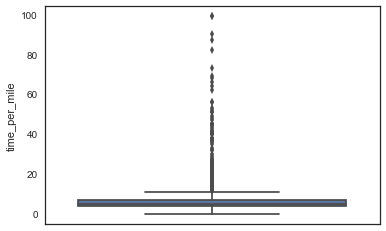

In [0]:
loc_trip_time_distance=loc_pickup_total

loc_trip_time_distance['dropoff_datetime']= pd.to_datetime(loc_trip_time_distance['dropoff_datetime'])
loc_trip_time_distance['pickup_datetime']= pd.to_datetime(loc_trip_time_distance['pickup_datetime'])
ride_time=loc_trip_time_distance['dropoff_datetime'] - loc_trip_time_distance['pickup_datetime']
ride_time=[i.total_seconds()//60 for i in ride_time]
loc_trip_time_distance['ride_time']=ride_time
loc_trip_time_distance['time_per_mile']=loc_trip_time_distance['ride_time']//loc_trip_time_distance['trip_distance']

sns.boxplot(loc_trip_time_distance.time_per_mile,orient='vertical')
loc_trip_time_distance.time_per_mile.describe()


In [0]:
# Being conservative: avg_mins_per_mile>=8
loc_trip_time_distance.loc[loc_trip_time_distance['time_per_mile']>=8,:].shape[0]

1858